In [68]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import os
import time
import matplotlib.pyplot as plt

In [69]:
os.cpu_count()

2

In [70]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

In [71]:
train_data = torchvision.datasets.CIFAR10(
    root = './data', train=True, download=True, transform=transform
)

test_data = torchvision.datasets.CIFAR10(
    root = './data', train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [72]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True
)

In [73]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [75]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    loss_list = []
    acc_list = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        loss_list.append(running_loss / len(train_loader))
        acc_list.append(acc)
        print(f'Epoch {epoch + 1}/{num_epochs}:\t Loss -- {running_loss / len(train_loader):.4f} \t Accuracy -- {acc}')

    return loss_list, acc_list

In [76]:
start_time = time.time()
loss_list, acc_list = train_model(model, train_loader, criterion, optimizer, num_epochs=20)
end_time = time.time()
duration = end_time - start_time
print(f'Training duration: {duration:.2f} seconds\t {(duration / 60):.2f} minutes')


Epoch 1/20:	 Loss -- 1.5393 	 Accuracy -- 44.136
Epoch 2/20:	 Loss -- 1.2302 	 Accuracy -- 56.01
Epoch 3/20:	 Loss -- 1.1088 	 Accuracy -- 60.832
Epoch 4/20:	 Loss -- 1.0310 	 Accuracy -- 63.466
Epoch 5/20:	 Loss -- 0.9781 	 Accuracy -- 65.516
Epoch 6/20:	 Loss -- 0.9295 	 Accuracy -- 67.316
Epoch 7/20:	 Loss -- 0.8919 	 Accuracy -- 68.978
Epoch 8/20:	 Loss -- 0.8576 	 Accuracy -- 69.862
Epoch 9/20:	 Loss -- 0.8332 	 Accuracy -- 70.792
Epoch 10/20:	 Loss -- 0.8013 	 Accuracy -- 71.994
Epoch 11/20:	 Loss -- 0.7769 	 Accuracy -- 72.638
Epoch 12/20:	 Loss -- 0.7573 	 Accuracy -- 73.422
Epoch 13/20:	 Loss -- 0.7376 	 Accuracy -- 74.308
Epoch 14/20:	 Loss -- 0.7192 	 Accuracy -- 74.988
Epoch 15/20:	 Loss -- 0.7002 	 Accuracy -- 75.508
Epoch 16/20:	 Loss -- 0.6873 	 Accuracy -- 75.92
Epoch 17/20:	 Loss -- 0.6706 	 Accuracy -- 76.602
Epoch 18/20:	 Loss -- 0.6614 	 Accuracy -- 77.078
Epoch 19/20:	 Loss -- 0.6454 	 Accuracy -- 77.396
Epoch 20/20:	 Loss -- 0.6334 	 Accuracy -- 77.786
Training du

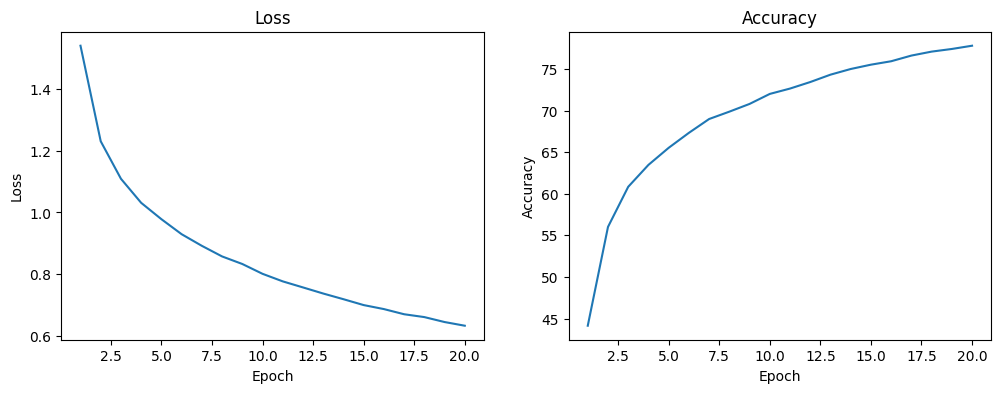

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(range(1, 21), loss_list)
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[1].plot(range(1, 21), acc_list)
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
plt.show()

In [78]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f'Accuracy: {acc:.2f}%')

In [79]:
evaluate_model(model, test_loader)

Accuracy: 76.06%
